In [1]:
import cartopy.crs as ccrs
import G211
import geopandas
import glob
import logging
import matplotlib.pyplot as plt
from matplotlib.colors import (
    BoundaryNorm, 
    ListedColormap, 
    LinearSegmentedColormap
)
%matplotlib inline
from ml_functions import (
    brier_skill_score,
    configs_match,
    get_argparser,
    get_features,
    get_savedmodel_path,
    load_df,
    rptdist2bool,
)
from multiprocessing.pool import Pool
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score, 
    roc_auc_score
)
from sklearn.model_selection import KFold
from spc import get_outlooks, get_issuance_time, convective_outlook_colors, enhtstm_colors
from statisticplot import make_map, stat_plots
from tensorflow.keras.models import load_model
from tqdm import tqdm
import warnings
import xarray
import yaml

logging.basicConfig(level=logging.WARNING, format='%(asctime)s %(message)s', force=True)

2023-07-01 12:41:44.691890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 12:41:44.804994: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# map projection
map_crs = G211.g211

In [3]:
# color map for SPC outlook
convective_outlook_colors
# color map for SPC enhanced tstm outlook
enhtstm_cmap = ListedColormap(list(enhtstm_colors.values()), name="tstm outlook")

In [4]:
import nclcmaps
test = nclcmaps.colors['MPL_Greys'][10:-10:] + nclcmaps.colors['MPL_Reds']
cmap = ListedColormap(test, "GreysReds")
norm = BoundaryNorm(np.arange(0,21,1), ncolors=cmap.N, clip=True)

In [5]:
x, y = np.meshgrid(range(G211.width),range(G211.height))
# assign 80-km grid points to geopandas dataframe
df = pd.DataFrame()
df["y"] = y.flatten()
df["x"] = x.flatten()
geometry = geopandas.points_from_xy(x=G211.lon.flatten(), y=G211.lat.flatten())
g211 = geopandas.GeoDataFrame(df.set_index(["y","x"]), geometry=geometry, crs=ccrs.PlateCarree())

In [6]:
def shp2ds(gs, issue, valid_start_hour, valid_end_hour):
    """
    convert geopandas dataframe to xarray dataset
    """
    df = G211.mask.to_dataframe(name="conus").join(gs.drop(columns="geometry").set_index(["y","x"]).sort_index())
    da = []
    for c in df.columns:
        da.append(xarray.DataArray(df[c].unstack("x").values, name=c, dims=["y","x"]))
    ds = xarray.merge(da)
    ds["issue"] = issue
    ds["valid_start_hour"] = valid_start_hour
    ds["valid_end_hour"] = valid_end_hour
    return ds

### Load SPC enhanced tstm outlook

In [7]:
search_str = os.path.join(os.getenv("TMPDIR"), "enhtstm", "????/*.zip")
logging.warning(search_str)
sfiles = sorted(glob.glob(search_str))

for ifile in tqdm(sfiles):
    base, ext = os.path.splitext(ifile)
    ofile = os.path.join(base + ".nc")
    if os.path.exists(ofile):
        continue
    gs = geopandas.read_file(ifile)
    
    issue, valid_start, valid_end = get_issuance_time(ifile)

    gs = g211.to_crs(gs.crs).sjoin(gs, how="inner", rsuffix='poly')
    # convert shapes to grid
    ds = shp2ds(gs, issue, valid_start_hour, valid_end_hour)
    
    ds.to_netcdf(ofile)

2023-07-01 12:41:48,984 /glade/scratch/ahijevyc/enhtstm/????/*.zip
100%|██████████| 11350/11350 [00:00<00:00, 120499.44it/s]


In [8]:
### SPC convective outlooks 
convoutlook = False
if convoutlook:
    agdf = get_outlooks()
    agdf.head(170).tail()

    # examples of SPC issuances with a particular risk threshold
    risk="ENH"
    ih = agdf["THRESHOLD"] == risk
    print(f"{sum(ih)} {risk} risk days")
    c = agdf.loc[ih].sort_values("PRODISS").PRODISS.values
    print(c[20::100])

In [9]:
ifile = sfiles[3000]
gs = geopandas.read_file(ifile)
issue, valid_start, valid_end = get_issuance_time(ifile)

# Assign value to g211 points within polygons
gs = g211.to_crs(gs.crs).sjoin(gs, how="inner", rsuffix='poly')
gs["issue"] = issue
gs["valid_start"] = valid_start.strftime('%Y%m%d %H:%M') # convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
gs["valid_end"] = valid_end.strftime('%Y%m%d %H:%M')
issue, valid_start, valid_end

('1300',
 datetime.datetime(2021, 5, 14, 20, 0),
 datetime.datetime(2021, 5, 15, 0, 0))

In [10]:
if convoutlook:
    import requests

    # Choose a particular convective outlook, grab issue time and expire time
    prodiss = '201803261955'
    issue = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].ISSUE.iloc[0])
    expire = pd.to_datetime(agdf[agdf.PRODISS.eq(prodiss)].EXPIRE.iloc[0])

    if issue < pd.to_datetime("20221128"):
        column = "THRESHOLD"
        subset = agdf["DAY"].eq(1) & agdf["CATEGORY"].eq("CATEGORICAL")
        subset = subset & agdf["PRODISS"].eq(prodiss)
        gdf = agdf[subset]
    else:
        ifile = requests.get("https://www.spc.noaa.gov/products/outlook/day1otlk_cat.nolyr.geojson")
        gdf = geopandas.GeoDataFrame.from_features(ifile.json())
        gdf = gdf.set_crs("epsg:4269")
        column = "LABEL"
    gdf

    if False:
        # Subtract higher thresholds from lower thresholds so they don't overlap
        cat = "TSTM"
        for subtract in ["MRGL", "SLGT", "ENH", "MDT", "HIGH"]:
            logging.debug(f"subtracting {subtract}")
            gdf.loc[gdf[column].eq(cat)] = gdf.loc[gdf[column].eq(cat)].overlay(gdf[gdf[column].eq(subtract)],
                                                                                      how="difference").values
            cat = subtract
            if subtract not in gdf[column]:
                break

In [11]:
spc_fcst=gs.to_crs(ccrs.PlateCarree())
column="DN"

## read lightning observations into xarray Datasets and convert either GLM Dataset (glmds) or Weatherbug dataset (cgds) to geopandas DataFrame (obsgdf)

In [12]:
def get_obsgdf(valid_start, valid_end, obsvar):
    if obsvar in ["cg","ic"]:
        wbugtimes = slice(valid_start, valid_end-pd.Timedelta(minutes=30))
        cgds = xarray.open_dataset(os.path.join("wbug_lightning", "flash_40km.nc"))
        df = cgds.sel(time_coverage_start = wbugtimes).sum(dim="time_coverage_start")
    elif obsvar == "flashes":
        glmtimes = pd.date_range(start=valid_start+pd.Timedelta(hours=1), end=valid_end-pd.Timedelta(hours=1), freq="2H")
        ifiles = [os.path.join("GLM", t.strftime("%Y"), t.strftime("%Y%m%d_%H%M")+".glm_40km_1hr.nc") for t in glmtimes]
        ifiles = [x for x in ifiles if os.path.exists(x)]
        if len(ifiles) == 0:
            logging.warning(f"no glm files for {glmtimes}")
            return None
        df = xarray.open_mfdataset(ifiles).sum(dim="time")
    else:
        logging.error(f"unexpected obsvar {obsvar}")

    # mask outside CONUS.
    # TODO: remake HRRR grid_data without masking outside CONUS to include water where flash data exists.
    df = df.where(G211.mask)
    df = df.to_dataframe().reset_index()
    obsgdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon,df.lat))
    obsgdf = obsgdf.set_crs(ccrs.PlateCarree())
    
    assert obsvar in obsgdf, f"{obsvar} not in obsgdf. did you assign the correct dataset?"
    return obsgdf

In [13]:
obsvar = "cg"
o_thresh = 50
obsgdf = get_obsgdf(valid_start, valid_end, obsvar)
obsgdf.explore(column=obsvar)

In [14]:
import folium 
m = spc_fcst.explore(column=column, 
                     categories=spc_fcst[column].unique().tolist(),
                     cmap=enhtstm_cmap, name="DN",
                     marker_kwds=dict(radius=4))
obsgdf[obsgdf[obsvar]>=o_thresh].explore(m=m, 
                                  marker_kwds=dict(color="yellow", fill=False), 
                                  name=f"{obsvar} ≥ {o_thresh}")
folium.LayerControl().add_to(m)
m

In [15]:
# MOS LAMP lightning forecast
LAMP=False
if LAMP:
    from awips.dataaccess import DataAccessLayer
    DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
    request = DataAccessLayer.newDataRequest()
    request.setDatatype("grid")
    request.setLocationNames("LAMP2p5")
    request.setParameters("PROLGHT2hr")
    #request.setLevels("2.0FHAG")

    # Take a look at our request
    logging.info(request)

    grid_locations = DataAccessLayer.getAvailableLevels(request)
    grid_locations.sort()
    list(grid_locations)

    cycles = DataAccessLayer.getAvailableTimes(request, True)
    times = DataAccessLayer.getAvailableTimes(request)
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

    # Get the most recent grid data
    response = DataAccessLayer.getGridData(request, [fcstRun[0]])

    logging.info(f"{len(times)} available times {len(fcstRun)} forecast runs")

    grid = response[0]
    data = grid.getRawData()
    lons, lats = grid.getLatLonCoords()
    bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

    data[data == -999999] = np.nan
    data.min()
    np.nanmin(data)

    fig, ax = make_map(bbox=bbox, projection = map_crs)
    cs = ax.pcolormesh(lons, lats, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
    cbar.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
                   + grid.getParameter() + " (" + grid.getUnit() + ") " \
                   + "valid " + str(grid.getDataTime().getRefTime()))

    fig2, ax2 = make_map(bbox=bbox, projection=map_crs)
    cs2 = ax2.contour(lons, lats, data, 80, cmap=cmap, levels=6,
                      transform=ccrs.PlateCarree(),
                      vmin=np.nanmin(data), vmax=np.nanmax(data))
    cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation='horizontal')
    cbar2.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
                   + grid.getParameter() + " (" + grid.getUnit() + ") " \
                   + "valid " + str(grid.getDataTime().getRefTime()))

## Define observation numpy array, geodataframe, thresholds

In [16]:
# simple 1-D numpy array of observations for verification
obs = obsgdf[obsvar].values.flatten()

# drop nans outside CONUS (mask applied earlier)
obs = obs[~np.isnan(obs)]

# truncate observation geodataframe based on event threshold (used for plots)
o=obsgdf[obsgdf[obsvar]>=o_thresh]

# Alternative event thresholds for observations (evenly spaced logrithmically)
thresh = np.round(
    np.logspace(0,3,16),
    decimals=0
).astype(int)
thresh = pd.Series(thresh, name=f"{obsvar} threshold")

### Verify SPC enhanced tstm forecast

In [17]:
fcst = spc_fcst
fcst = fcst.merge(g211, on=["x","y"], how="right") # so we can apply 6045-element mask
fcst = fcst.DN.values.flatten()/100
# Drop values outside CONUS
fcst = fcst[G211.mask.values.flatten()]
# Assign 0 to points outside forecast polygons
fcst[np.isnan(fcst)] = 0

pthresh = pd.Series([10,40,70], name=f"fcst prob\nthresh")/100.

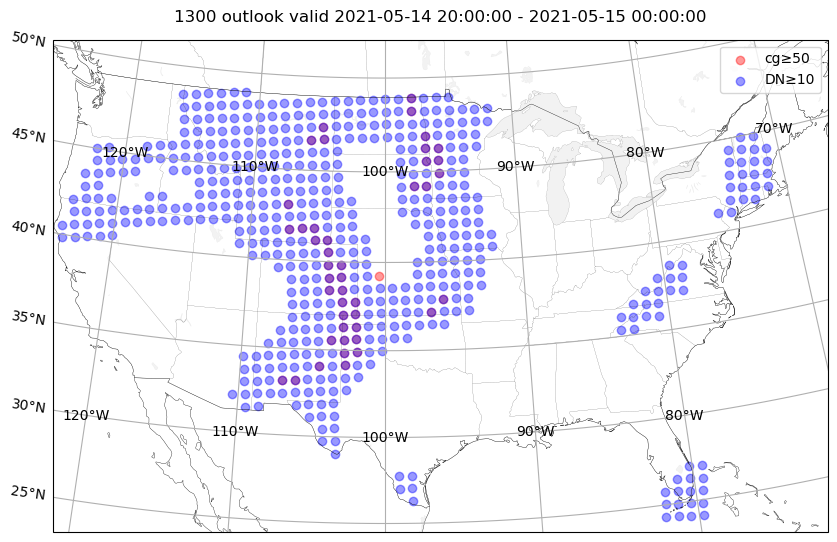

In [18]:
fig, ax = make_map()
f_thresh = 10
assert f_thresh in [10,40,70]
ax.set_title(f"{issue} outlook valid {valid_start} - {valid_end}")
o.plot(color="red", alpha=0.4, ax = ax, transform=ccrs.PlateCarree(), label=f'{obsvar}≥{o_thresh}')
spc_fcst[spc_fcst.DN >= f_thresh].plot(color="blue", alpha=0.4, ax=ax, transform=ccrs.PlateCarree(), label=f"DN≥{f_thresh}")

leg=ax.legend()

  0%|          | 0/16 [00:00<?, ?it/s]/glade/u/home/ahijevyc/statisticplot.py:172: RuntimeWarning: divide by zero encountered in scalar divide
  return fcst.sum()/obs.sum()
/glade/u/home/ahijevyc/statisticplot.py:172: RuntimeWarning: invalid value encountered in scalar divide
  return fcst.sum()/obs.sum()
  0%|          | 0/16 [00:00<?, ?it/s]/glade/u/home/ahijevyc/statisticplot.py:180: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
  0%|          | 0/16 [00:00<?, ?it/s]/glade/u/home/ahijevyc/statisticplot.py:184: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)
100%|██████████| 16/16 [00:00<00:00, 1153.89it/s]
/glade/u/home/ahijevyc/statisticplot.py:184: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)
/glade/u/home/ahijevyc/statisticplot.py:170: RuntimeWarning: invalid value encountered in scalar divide
  return fp/(fp+tp)


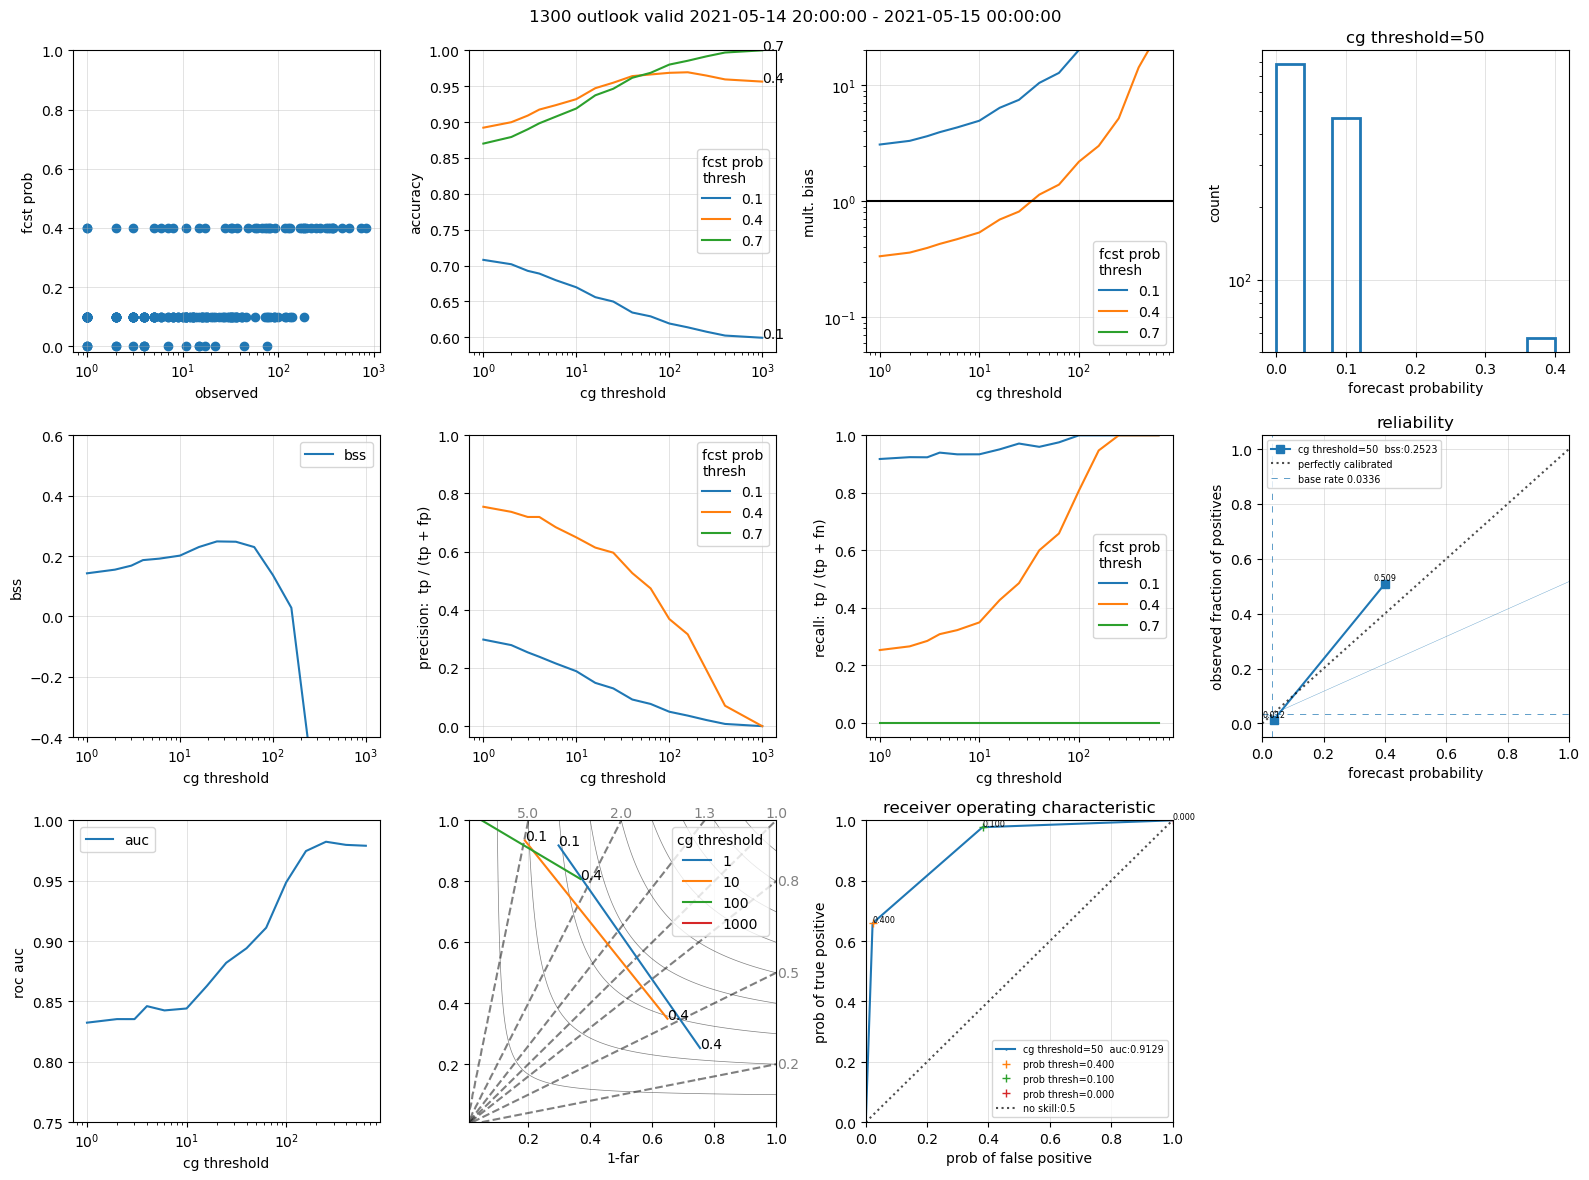

In [19]:
axes = stat_plots(obs, fcst, thresh=thresh, pthresh=pthresh, o_thresh=o_thresh, sep=0.01, suptitle=f"{issue} outlook valid {valid_start} - {valid_end}")

## Verify dense neural network forecast

In [20]:
parser = get_argparser()
rptdist = 40
twin = 2
rpttwin = int(np.floor(twin/2)) # Ryan's original way of naming storm rpt time windows
args = parser.parse_args(args="--model HRRR --batchsize 1024 --neurons 1024 --optim SGD"
                         " --trainstart 20191002 --trainend 20201202 "
                         f"--flash {o_thresh} "
                         f"--savedmodel nn/lightning/{o_thresh:02d}flash.{twin}hr "
                         f"--labels sighail_{rptdist}km_{rpttwin}hr sigwind_{rptdist}km_{rpttwin}hr "
                         f"hailone_{rptdist}km_{rpttwin}hr wind_{rptdist}km_{rpttwin}hr torn_{rptdist}km_{rpttwin}hr any_{rptdist}km_{rpttwin}hr "
                         f"cg_{rptdist}km_{twin}hr ic_{rptdist}km_{twin}hr  cg.ic_{rptdist}km_{twin}hr  flashes_{rptdist}km_{twin}hr "
                         " --epochs 10 --learning 0.001 --kfold 1".split())
setattr(args, "idate", pd.to_datetime(valid_start).floor("1D")) 
savedmodel = get_savedmodel_path(args)
logging.warning(f"savemodel={savedmodel}")
args

2023-07-01 12:41:55,989 savemodel=nn/lightning/50flash.2hr


Namespace(batchnorm=False, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=10, labels=['sighail_40km_1hr', 'sigwind_40km_1hr', 'hailone_40km_1hr', 'wind_40km_1hr', 'torn_40km_1hr', 'any_40km_1hr', 'cg_40km_2hr', 'ic_40km_2hr', 'cg.ic_40km_2hr', 'flashes_40km_2hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=50, folds=None, kfold=1, idate=Timestamp('2021-05-14 00:00:00'), ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='SGD', reg_penalty=0.01, savedmodel='nn/lightning/50flash.2hr', seed=None, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('2019-10-02 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 12:00:00'), suite='default')

In [21]:
df = load_df(args)

df = rptdist2bool(df, args)

2023-07-01 12:41:56,729 using [0, 1, 2] time windows for ['sighail', 'sigwind', 'hailone', 'wind', 'torn'] until we update parquet files with [1,2,4]
2023-07-01 12:41:56,739 using [0, 1, 2] time windows for ['sighail', 'sigwind', 'hailone', 'wind', 'torn'] until we update parquet files with [1,2,4]


In [22]:
feature_list = get_features(args)

beforedropna = len(df)
logging.info(
    f"Retain rows where all {len(feature_list)} requested features are present")
df = df.dropna(axis="index", subset=feature_list)
logging.info(f"kept {len(df)}/{beforedropna} cases with no NA features")

columns_before_filtering = df.columns
df = df[feature_list]
logging.info(
    f"dropped {set(columns_before_filtering) - set(df.columns)}")
logging.info(
    f"kept {len(df.columns)}/{len(columns_before_filtering)} features")

In [23]:
def predct(i):
    ifold, thisfit = i
    savedmodel_thisfitfold = f"{savedmodel}_{thisfit}/{args.kfold}fold{ifold}"
    logging.warning(f"{i} {savedmodel_thisfitfold}")
    yl = yaml.load(open(
        os.path.join(savedmodel_thisfitfold, "config.yaml"), "r"),
        Loader=yaml.Loader)
    if "labels" in yl:
        labels = yl["labels"]
        # delete labels so we can make DataFrame from rest of dictionary.
        del (yl["labels"])
    else:
        labels = getattr(yl["args"], "labels")
        
    assert configs_match(
        yl["args"], args
    ), f'this configuration {args} does not match yaml file {yl["args"]}'
    del (yl["args"])
    # scaling values DataFrame as from .describe()
    sv = pd.DataFrame(yl).set_index("columns").T
    if sv.columns.size != df.columns.size:
        logging.error(
            f"size of yaml and features columns differ {sv.columns} {df.columns}"
        )
    assert all(
        sv.columns == df.columns
    ), f"columns {df.columns} don't match when model was trained {sv.columns}"

    logging.info(f"loading {savedmodel_thisfitfold}")
    model = load_model(
        savedmodel_thisfitfold)
    norm_features = (df - sv.loc["mean"]) / sv.loc["std"]
    # Grab numpy array of predictions.
    Y = model.predict(norm_features.to_numpy(
        dtype='float32'), batch_size=10000)
    Y = pd.DataFrame(Y, columns=labels, index=df.index)
    return Y


index = pd.MultiIndex.from_product(
    [range(args.kfold), range(args.nfits)], names=["fold", "fit"])
# Remember to request multiple cpus and >76G memory per node when starting jupyter
with Pool(processes=index.size) as pool:
    result = pool.map(predct, index)
y_preds = pd.concat(result, keys=index, names=index.names)

2023-07-01 12:41:57,072 (0, 2) nn/lightning/50flash.2hr_2/1fold0
2023-07-01 12:41:57,065 (0, 0) nn/lightning/50flash.2hr_0/1fold0
2023-07-01 12:41:57,069 (0, 1) nn/lightning/50flash.2hr_1/1fold0
2023-07-01 12:41:57,072 (0, 3) nn/lightning/50flash.2hr_3/1fold0
2023-07-01 12:41:57,075 (0, 4) nn/lightning/50flash.2hr_4/1fold0
2023-07-01 12:41:57.256184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 12:41:57.262364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enab

7/7 [==============================] - 1s 43ms/step


In [24]:
# I may have overlapping valid_times from different init_times like fhr=1 from today and fhr=25 from previous day
# average probability over all nfits initialized at initialization_time and valid at valid_time
ensmean = y_preds.groupby(level=[
    "valid_time", "y", "x"
]).mean()
assert "fit" not in ensmean.index.names, "fit should not be a MultiIndex level of ensmean, the average probability over nfits."

In [25]:
dnntimes = pd.date_range(start=valid_start+pd.Timedelta(hours=1), end=valid_end-pd.Timedelta(hours=1), freq=f"{twin}H")
ensmean = ensmean.loc[dnntimes]

ensmean.groupby("valid_time").first().index

DatetimeIndex(['2021-05-14 21:00:00', '2021-05-14 23:00:00'], dtype='datetime64[ns]', name='valid_time', freq=None)

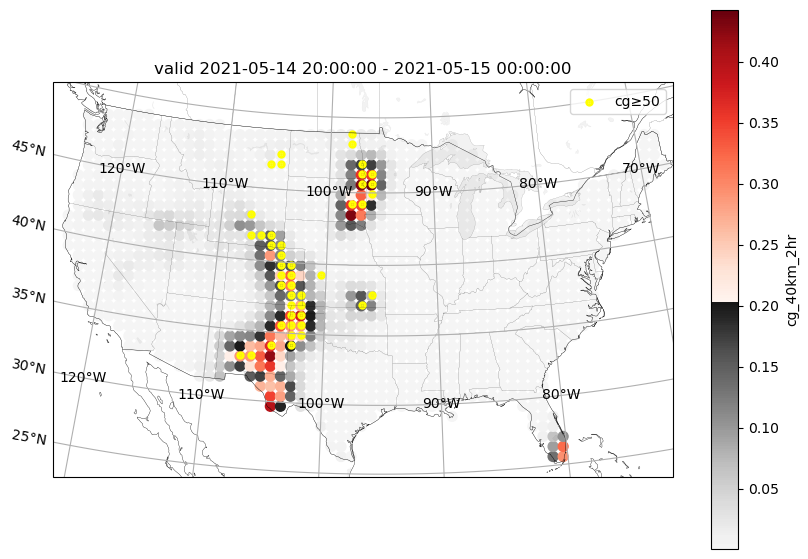

In [26]:
fig, ax = make_map(projection=map_crs)
f = f"{obsvar}_{rptdist}km_{twin}hr"

# probability of no occurences during long time window = product of 1-p for all 
# smaller time window pieces

prob_none = (1-ensmean).groupby(["y","x"]).prod()
# 1 minus prob_none = prob of at least one occurence.
p = 1 - prob_none
# add to df so we can use df's lat and lon for coordinates.
p["lon"] = df.groupby(["y","x"]).mean(numeric_only=True).lon
p["lat"] = df.groupby(["y","x"]).mean(numeric_only=True).lat
p.plot(ax=ax, cmap=cmap, c=f,
                       kind="scatter",x="lon",y="lat",
                       s=50, marker="o",
                       transform=ccrs.PlateCarree())
ax.set_title(f"valid {valid_start} - {valid_end}")
ox = o.plot(ax=ax, transform=ccrs.PlateCarree(), 
                     marker="o", markersize=4, color="yellow",
                     label=f"{obsvar}≥{o_thresh}", linewidths=4)
leg = ox.legend()

In [27]:
fcst = p[f].values.flatten()

pthresh = pd.Series(np.round(np.arange(0.2,1,.2),2), name=f"fcst\np thresh")

  0%|          | 0/16 [00:00<?, ?it/s]/glade/u/home/ahijevyc/statisticplot.py:172: RuntimeWarning: divide by zero encountered in scalar divide
  return fcst.sum()/obs.sum()
/glade/u/home/ahijevyc/statisticplot.py:172: RuntimeWarning: invalid value encountered in scalar divide
  return fcst.sum()/obs.sum()
  0%|          | 0/16 [00:00<?, ?it/s]/glade/u/home/ahijevyc/statisticplot.py:180: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
  0%|          | 0/16 [00:00<?, ?it/s]/glade/u/home/ahijevyc/statisticplot.py:184: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)
100%|██████████| 16/16 [00:00<00:00, 1069.87it/s]
/glade/u/home/ahijevyc/statisticplot.py:184: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)
/glade/u/home/ahijevyc/statisticplot.py:170: RuntimeWarning: invalid value encountered in scalar divide
  return fp/(fp+tp)


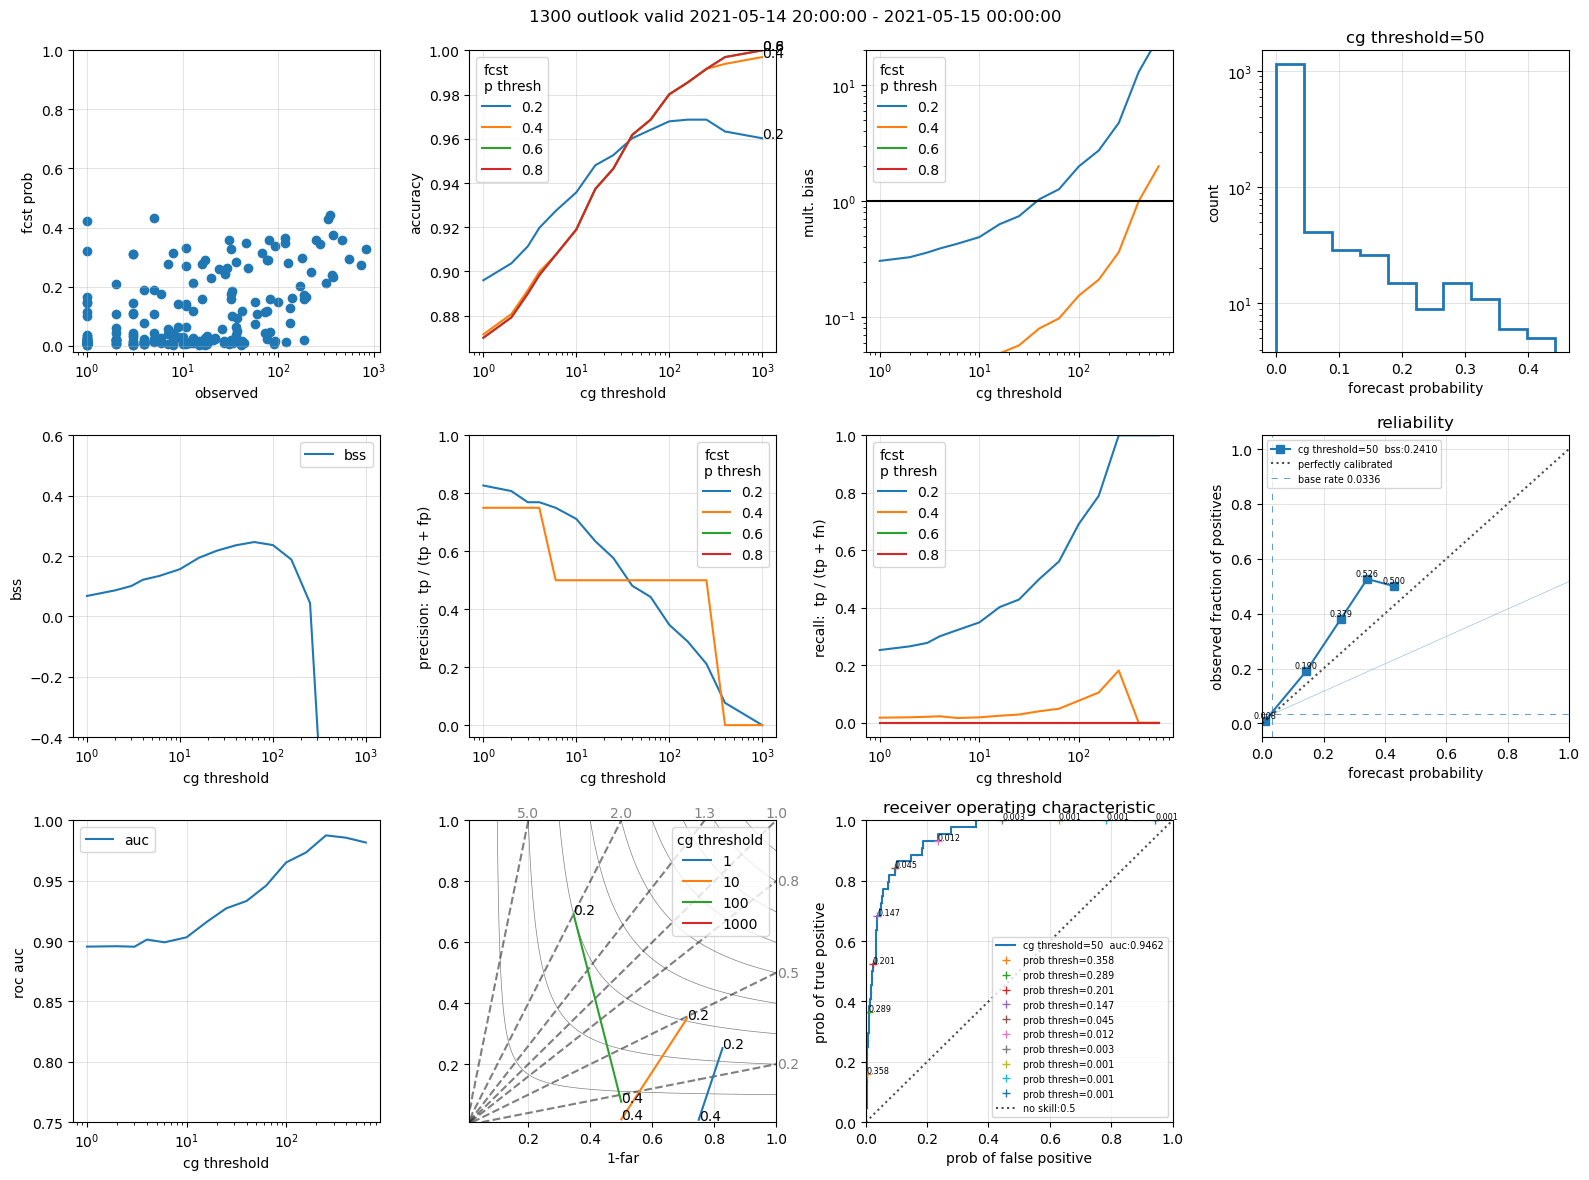

In [28]:
axes = stat_plots(obs, fcst, thresh=thresh, pthresh=pthresh, o_thresh=o_thresh, sep=0.15, suptitle=f"{issue} outlook valid {valid_start} - {valid_end}")

In [29]:
from sklearn import metrics

def recall_score(obs, fcst):
    tp = (obs & fcst).sum()
    fn = (obs & ~fcst).sum()
    return tp/(tp+fn)
    return np.where(tp+fn==0, 0, tp/(tp+fn))

In [30]:
%timeit [recall_score(obs > t, fcst>=pt) for t in thresh.values for pt in pthresh.values]

/glade/scratch/ahijevyc/ipykernel_63426/2095547663.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fn)


645 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%timeit [metrics.recall_score(obs > t, fcst>=pt, zero_division=0) for t in thresh for pt in pthresh]

53.5 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
